# A5.1 Reinforcement Learning for Marble with Variable Goal

For this assignment, start with the `19 Reinforcement Learning Modular Framework` notebook.  Recall that this code used reinforcement learning to learn to push a marble towards the goal position of 5 and keep it there.

The objective of the following required modification is an agent that has been trained to directly move the marble to a specified goal without any further training. 

<font color="red">Modify the code</font> to allow any goal position from 1 to 9.  First, rename the `Marble` class to `Marble_Variable_Goal`.  Then, modify the `Marble_Variable_Goal` class so that it includes the goal in the state, allowing the agent to learn to push the marble to any given goal.  Modify the `intial_state` function to set the goal to a random integer from 1 to 9.

<font color='red'>Do not modify</font> the `Qnet` class. It should run correctly when applied to your new `Marble_Variable_Goal` class.

<font color='red'>Discuss</font> what you modified in the code for this assignment.

<font color='red'>Add some code</font> at the end of the notebook that applies the trained agent to the marble at goals from 1 to 9.  For each goal, start the marble at positions 0 through 10 with zero velocity and the specified goal and applies the trained agent to control the marble for 200 steps.  Calculate the distance of the final state from the goal.  Average this distance over all starting positions for the specified goal and store in a numpy array with one row for each goal and each row containing the goal and the average of distances to goal over all starting positions. Call this numpy array, `distances_to_goal`.  Plot the results of these average distances versus the goal.

<font color='red'>Explore different parameter values</font>, including the network hidden layer structure, number of trials, number of steps per trial, learning rate, number of epochs, and final epsilon value to try to get the best results for `distances_to_goal`. Try just three or four different values for each parameter, varying one parameter value at a time. After you have found some parameter values that often work well, set the parameters to these values and run again to produce the graphs from `plot_status` showing the results with these parameters. But, first <font color='red'>modify `plot_status` code</font> for subplots 6 and 9 so that the vertical pink goal region correctly shows the current goal.  Add the current goal to the title of the subplot 9.

<font color='red'>Discuss</font> the results, and discuss which parameter values seem to perform well.

Here is some code and parameter values that I have found to be successful...usually.  As you know, results vary quite a bit from one run to another. Understand that you will not find parameter values that work perfectly every time.  You are welcome to start with these parameter values and experiment with variations of these.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks_A4 as nn   # from A4

from IPython.display import display, clear_output

In [2]:
from abc import ABC, abstractmethod
    
class Environment(ABC):
    
    def __init__(self, valid_actions):
        self.valid_actions = valid_actions

    @abstractmethod
    def initial_state(self):
        return state  # the initial state
    
    @abstractmethod
    def next_state(self, state, action):
        return next_state  
    
    @abstractmethod
    def reinforcement(self, state):
        return r # scalar reinforcement
   
    def terminal_state(self, state):
        return False  # True if state is terminal state

In [3]:
class Marble_Variable_Goal(Environment):

    def __init__(self, valid_actions):
        super().__init__(valid_actions)
        
    def initial_state(self):
        return np.array([10 * np.random.uniform(), 0.0, np.random.randint(1,10,1)], dtype=float)

    def next_state(self, state, action):
        '''state[0] is position, state[1] is velocity and state[2] is goal'''    
        next_state = state.copy()
        deltaT = 0.1                           # Euler integration time step
        next_state[0] += deltaT * state[1]                  # Update position
        force = action
        mass = 0.5
        next_state[1] += deltaT * (force / mass - 0.2 * state[1])  # Update velocity. Includes friction

        # Bound next position. If at limits, set velocity to 0.
        if next_state[0] < 0:        
            next_state = [0., 0., state[2]]    # these constants as ints were causing the errors we discussed in class.
        elif next_state[0] > 10:
            next_state = [10., 0., state[2]]

        return next_state

    def reinforcement(self, state):
        global goal
        goal = state[2]
        return 0 if abs(state[0]- goal) < 1 else -1

    def terminal_state(self, state):
        return False

In [4]:
class Agent(ABC):
    
    def __init__(self, environment):
        self.environment = environment

    @abstractmethod
    def make_samples(self, n_samples, epsilon):
        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i+1]:
                Qn[i] = self.use(X[i+1])
        return Qn

    def epsilon_greedy(self, state, epsilon):
        valid_actions = self.environment.valid_actions

        if np.random.uniform() < epsilon:
            # Random Move
            action = np.random.choice(valid_actions)
        else:
            # Greedy Move
            Qs = [self.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
            ai = np.argmax(Qs)
            action = valid_actions[ai]

        return action

    @abstractmethod
    def train(self):
        return

    @abstractmethod
    def use(self, X):
        return # Q values for each row of X, each consisting of state and action

In [5]:
class Qnet(Agent):

    def __init__(self, environment, hidden_layers, X_means=None, X_stds=None, Q_means=None, Q_stds=None):
        self.environment = environment
        state_size = environment.initial_state().size  # assumes state is an np.array
        valid_actions = environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        self.Qnet = nn.NeuralNetwork(state_size + action_size, hidden_layers, 1)
        if X_means:
            self.Qnet.X_means = np.array(X_means)
            self.Qnet.X_stds = np.array(X_stds)
            self.Qnet.T_means = np.array(Q_means)
            self.Qnet.T_stds = np.array(Q_stds)

    def make_samples(self, n_samples, epsilon):
 
        state_size = self.environment.initial_state().size  # assumes state is an np.array
        valid_actions = self.environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        X = np.zeros((n_samples, state_size + action_size))
        R = np.zeros((n_samples, 1))
        Qn = np.zeros((n_samples, 1))
        terminal_state = np.zeros((n_samples, 1), dtype=bool)  # All False values

        state = self.environment.initial_state()
        state = self.environment.next_state(state, 0)        # Update state, sn from s and a
        action = self.epsilon_greedy(state, epsilon)

        # Collect data from n_samples steps
        for step in range(n_samples):

            next_state = self.environment.next_state(state, action)        # Update state, sn from s and a
            r = self.environment.reinforcement(state)   # Calculate resulting reinforcement
            next_action = self.epsilon_greedy(next_state, epsilon)
            X[step, :] = np.hstack((state, action))
            R[step, 0] = r
            if self.environment.terminal_state(state):
                terminal_state[step, 0] = True
                Qn[step, 0] = 0
            else:
                Qn[step, 0] = self.use(np.hstack((next_state, next_action)))
            # Advance one time step
            state, action = next_state, next_action

        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i+1]:
                Qn[i] = self.use(X[i+1])
        return Qn

    def train(self, n_trials, n_steps_per_trial, n_epochs, method, learning_rate, 
              gamma, epsilon, final_epsilon,
              trial_callback=None):

        if trial_callback:
            fig = plt.figure(figsize=(10, 10))
            
        epsilon_decay =  np.exp(np.log(final_epsilon) / n_trials) # to produce this final value
        print('epsilon_decay is', epsilon_decay)
        epsilon_trace = np.zeros(n_trials)
        r_trace = np.zeros(n_trials)

        for trial in range(n_trials):

            X, R, Qn, terminal_state = self.make_samples(n_steps_per_trial, epsilon)

            for epoch in range(n_epochs):
                self.Qnet.train(X, R + gamma * Qn, 1,  method=method, learning_rate=learning_rate, batch_size=-1, verbose=False)
                self.update_Qn(X, Qn, terminal_state)

            epsilon *= epsilon_decay

            # Rest is for plotting
            epsilon_trace[trial] = epsilon
            r_trace[trial] = np.mean(R)

            if trial_callback and (trial + 1 == n_trials or trial % (n_trials / 50) == 0):
                fig.clf()
                trial_callback(agent, trial, n_trials, X, epsilon_trace, r_trace)
                clear_output(wait=True)
                display(fig)

        if trial_callback:
            clear_output(wait=True)

        return epsilon_trace, r_trace

    def use(self, X):
        return self.Qnet.use(X)

In [6]:
from matplotlib import cm

def plot_status(agent, trial, n_trials, X, epsilon_trace, r_trace):
    

    plt.subplot(3, 3, 1)
    plt.plot(epsilon_trace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
               
    plt.subplot(3, 3, 2)
    plt.plot(r_trace[:trial + 1], alpha=0.5)
    plt.ylabel('Mean reinforcement')
        
    valid_actions = agent.environment.valid_actions

    qs = agent.use(np.array([[s, 0, goal, a] for a in valid_actions for s in range(11)]))
               
    plt.subplot(3, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(valid_actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2,'Policy for Zero Velocity')
    plt.axis('off')
               
               
    plt.subplot(3, 3, 4)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = agent.use(np.array([[xsflat[i], ysflat[i], goal, a] for a in valid_actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(valid_actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax, 20, cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
               
    plt.subplot(3, 3, 5)
    acts = np.array(valid_actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2], cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    plt.subplot(3, 3, 6)
    plt.plot(X[:, 0], X[: ,1])
    plt.plot(X[-1, 0], X[-1, 1], 'ro')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([goal-1, goal+1], [-5, -5], [5, 5], color='red', alpha=0.3) 
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.title('Last Trial')

    ax = plt.subplot(3, 3, 7, projection='3d')
    ax.plot_surface(xs, ys, qsmax, linewidth=0, cmap=cm.coolwarm)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    ax = plt.subplot(3, 3, 8, projection='3d')
    ax.plot_surface(xs, ys, acts, cmap=cm.coolwarm, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    test_it(agent, 10, 500)

    plt.tight_layout()

def test_it(agent, n_trials, n_steps_per_trial):
    xs = np.linspace(0, 10, n_trials)
    plt.subplot(3, 3, 9) 
    
    # For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
    for x in xs:
        
        s = [x, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps_per_trial, 3))
        for step in range(n_steps_per_trial):
            a = agent.epsilon_greedy(s, 0.0) # epsilon = 0
            s = agent.environment.next_state(s, a)
            x_trace[step, :] = s
            
        plt.plot(x_trace[:, 0], x_trace[:, 1])
        plt.plot(x_trace[-1, 0], x_trace[-1, 1], 'ro')
        plt.fill_between([goal-1, goal+1], [-5, -5], [5, 5], color='pink', alpha=0.3)
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for goal = ' + str(goal) + '')

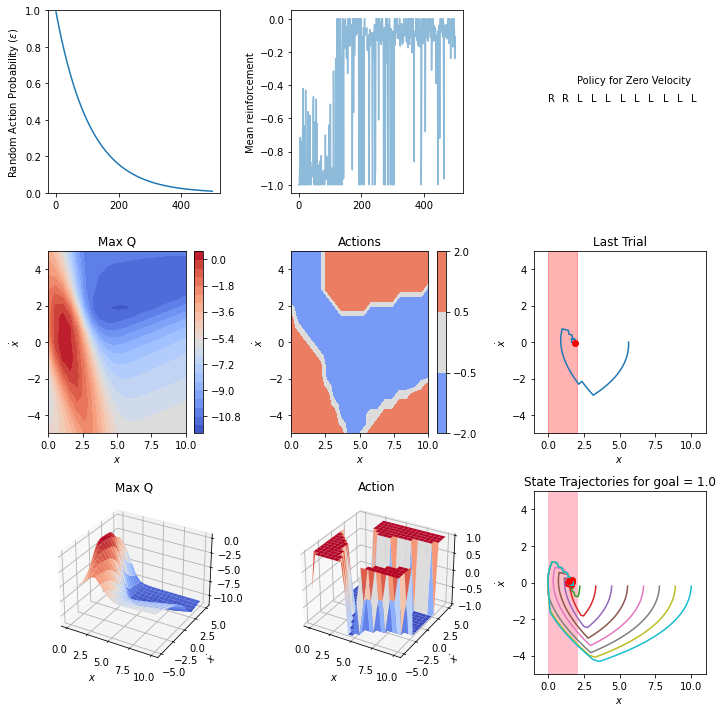

In [7]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[10, 10],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

In [8]:
def dist_to_goal(agent, n_steps_per_trial):
    x = []
    y = []
    for goal1 in range(1,10):
        for pos1 in range(11):
            s = [pos1, 0, goal1]
            for step in range(n_steps_per_trial):
                a = agent.epsilon_greedy(s, 0.0) # epsilon = 0
                s = agent.environment.next_state(s, a)
            x.append(np.absolute(s[0]-goal1))
        y.append(np.mean(np.asarray(x)))
    return y

In [9]:
distances_to_goal = dist_to_goal(agent, 200)
print(distances_to_goal)

[0.5337855933422916, 0.4414387274879283, 0.3015095827851065, 0.2291319572873257, 0.18465090592130234, 0.15514181691035192, 0.13490240428307185, 0.12027317269657421, 0.10951404405169102]


               Average distance between position and goal
Goal Position                                            
1                                                0.533786
2                                                0.441439
3                                                0.301510
4                                                0.229132
5                                                0.184651
6                                                0.155142
7                                                0.134902
8                                                0.120273
9                                                0.109514


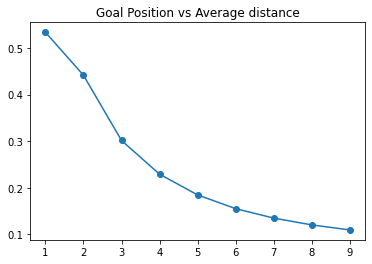

In [10]:
import pandas as pd

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

## Experiments: Explore for different parameter values best results for distances_to_goal

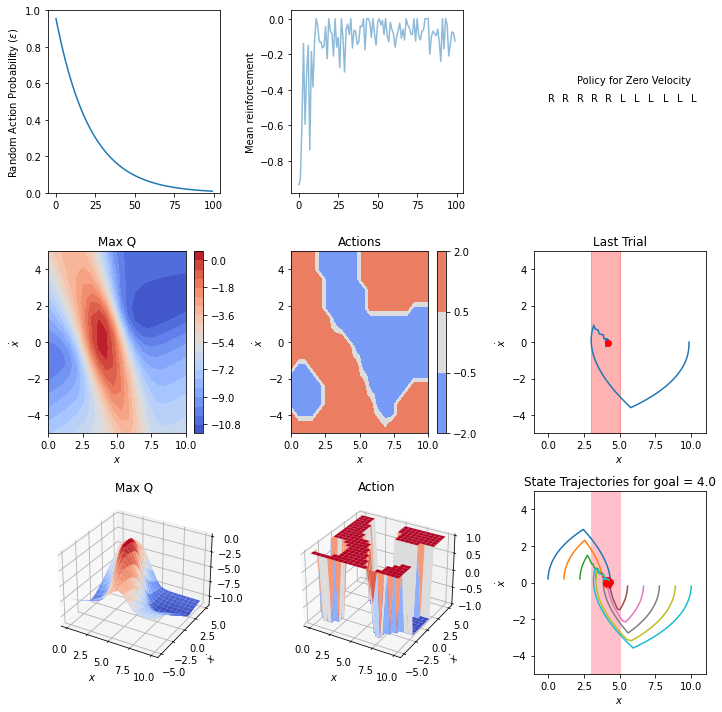

In [11]:
epsilon_trace, r_trace =  agent.train(n_trials=100, n_steps_per_trial=200, n_epochs=10,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

               Average distance between position and goal
Goal Position                                            
1                                                0.213942
2                                                0.182648
3                                                0.166657
4                                                0.155930
5                                                0.149325
6                                                0.152121
7                                                0.161015
8                                                0.175459
9                                                0.190727


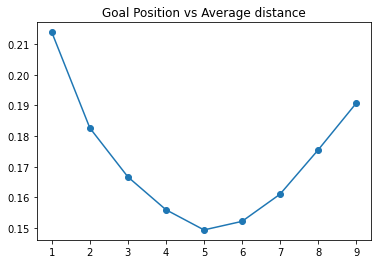

In [12]:
distances_to_goal = dist_to_goal(agent, 200)

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

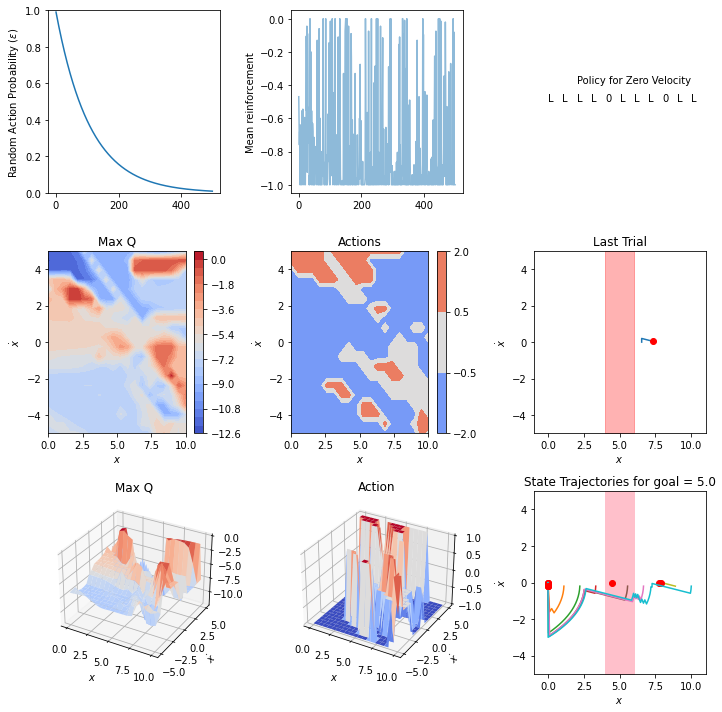

In [13]:
epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='adam', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

               Average distance between position and goal
Goal Position                                            
1                                                3.821246
2                                                2.910623
3                                                3.061627
4                                                3.364402
5                                                3.502585
6                                                3.691820
7                                                3.878703
8                                                3.882501
9                                                3.875355


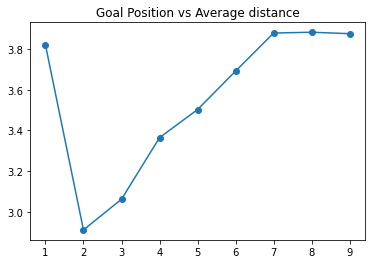

In [14]:
distances_to_goal = dist_to_goal(agent, 200)

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

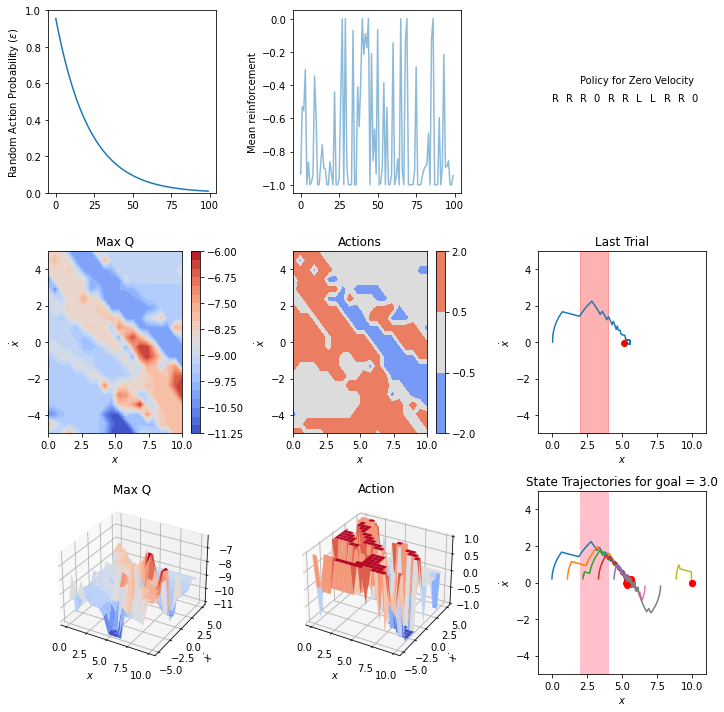

In [15]:
epsilon_trace, r_trace =  agent.train(n_trials=100, n_steps_per_trial=200, n_epochs=10,
                                      method='adam', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

               Average distance between position and goal
Goal Position                                            
1                                                7.657576
2                                                7.282190
3                                                6.003435
4                                                4.861662
5                                                4.441250
6                                                4.126773
7                                                3.927791
8                                                3.764738
9                                                3.447444


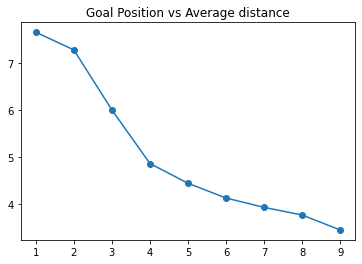

In [16]:
distances_to_goal = dist_to_goal(agent, 200)

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

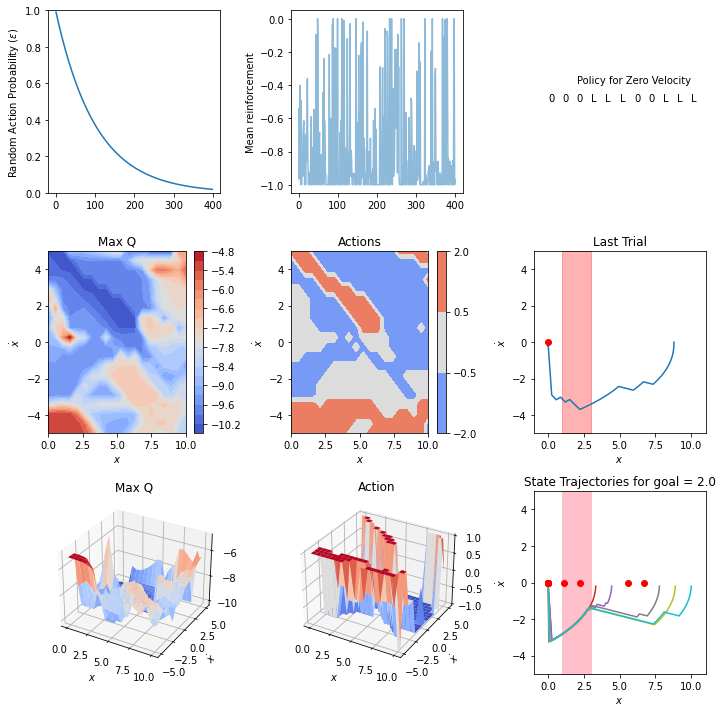

In [17]:
epsilon_trace, r_trace =  agent.train(n_trials=400, n_steps_per_trial=200, n_epochs=50,
                                      method='sgd', learning_rate=0.1, gamma=0.9,
                                      epsilon=1, final_epsilon=0.02,
                                      trial_callback=plot_status)

               Average distance between position and goal
Goal Position                                            
1                                                0.909091
2                                                1.545455
3                                                2.030303
4                                                2.568182
5                                                2.666953
6                                                2.843673
7                                                2.840031
8                                                2.916644
9                                                3.501664


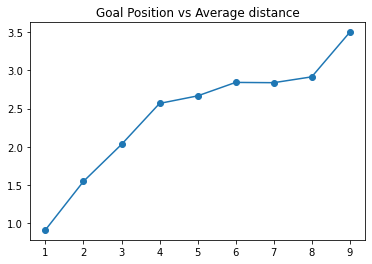

In [18]:
distances_to_goal = dist_to_goal(agent, 200)

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

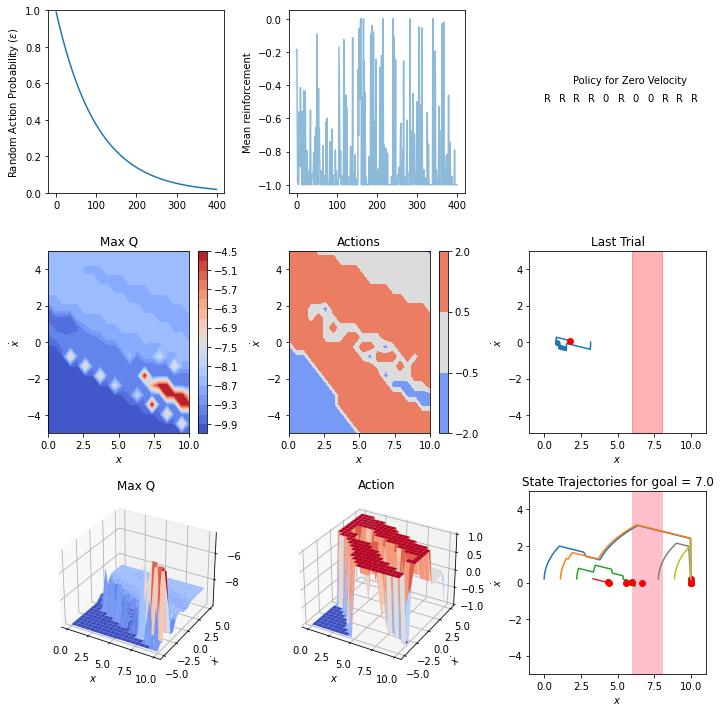

In [19]:
epsilon_trace, r_trace =  agent.train(n_trials=400, n_steps_per_trial=200, n_epochs=50,
                                      method='adam', learning_rate=0.1, gamma=0.9,
                                      epsilon=1, final_epsilon=0.02,
                                      trial_callback=plot_status)

               Average distance between position and goal
Goal Position                                            
1                                                5.559353
2                                                4.843184
3                                                4.614574
4                                                4.808608
5                                                4.746698
6                                                4.591945
7                                                4.248391
8                                                3.907798
9                                                3.781702


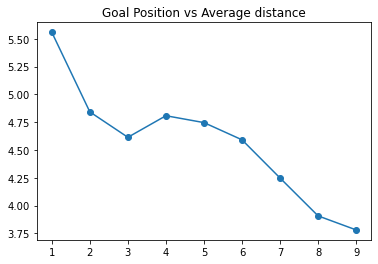

In [20]:
distances_to_goal = dist_to_goal(agent, 200)

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

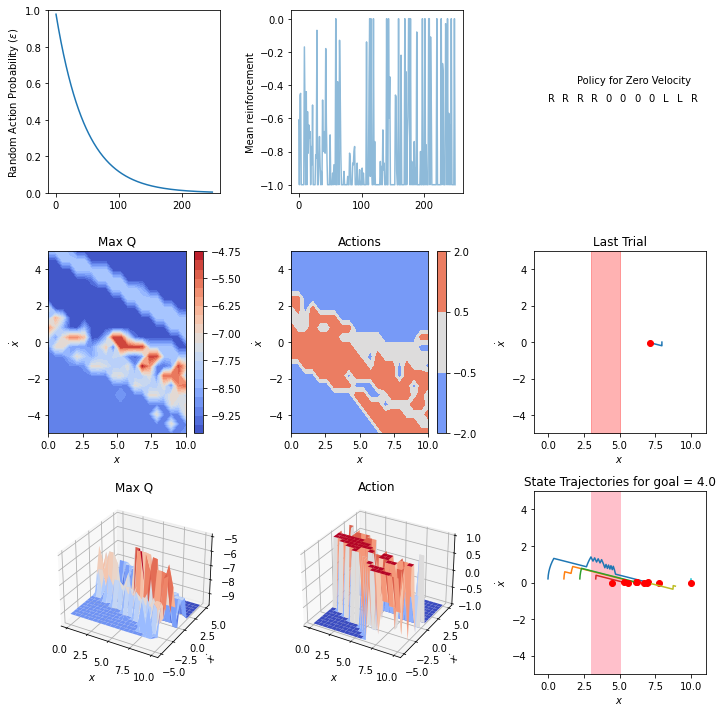

In [21]:
epsilon_trace, r_trace =  agent.train(n_trials=250, n_steps_per_trial=100, n_epochs=25,
                                      method='sgd', learning_rate=0.05, gamma=0.9,
                                      epsilon=1, final_epsilon=0.005,
                                      trial_callback=plot_status)

               Average distance between position and goal
Goal Position                                            
1                                                3.415453
2                                                3.135480
3                                                2.963270
4                                                2.792479
5                                                2.669282
6                                                2.674623
7                                                2.818216
8                                                3.031227
9                                                3.226316


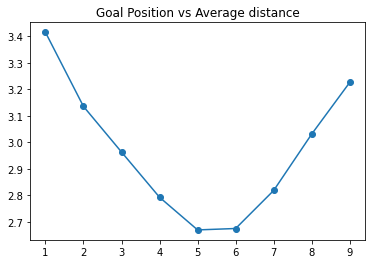

In [22]:
distances_to_goal = dist_to_goal(agent, 100)

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

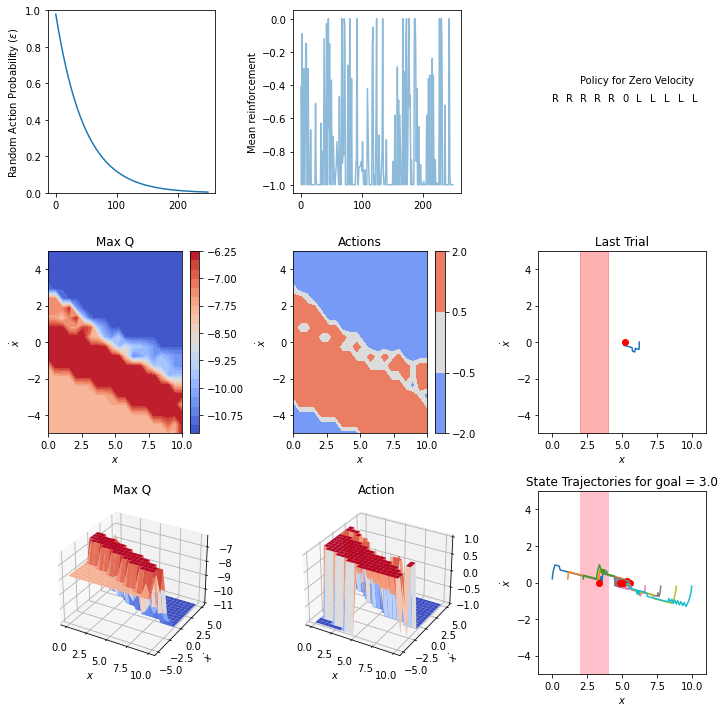

In [23]:
epsilon_trace, r_trace =  agent.train(n_trials=250, n_steps_per_trial=100, n_epochs=25,
                                      method='adam', learning_rate=0.05, gamma=0.9,
                                      epsilon=1, final_epsilon=0.005,
                                      trial_callback=plot_status)

               Average distance between position and goal
Goal Position                                            
1                                                4.111246
2                                                3.723580
3                                                3.074606
4                                                2.564595
5                                                2.618368
6                                                2.704239
7                                                2.817223
8                                                2.958793
9                                                3.180042


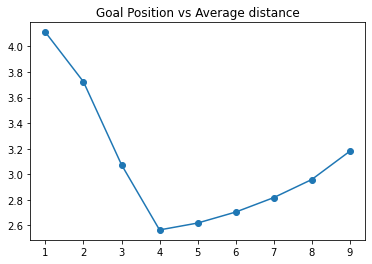

In [24]:
distances_to_goal = dist_to_goal(agent, 100)

goal_position = []

for g in range(1,10):
    goal_position.append(g)

data = {'Goal Position': goal_position, 
        'Average distance between position and goal': distances_to_goal}
df=pd.DataFrame(data)
df1=df.set_index("Goal Position")
print(df1)
plt.plot(goal_position, distances_to_goal, 'o-')
plt.title("Goal Position vs Average distance")
plt.show();

## Modifications made compared to 19 Reinforcement Learning Modular Framework

1) In both initial_state and next_state functions of class Marble_Variable_Goal, the state has been initialized with three arguments state[0]=position, state[1]=velocity and state[2]=goal, whereas the state in notebook 19 will be initialized with two arguments state[0]=position and state[1]=velocity. To generate random integer goal positions from range 1 to 9, np.random.randint(1,10,1) code is used in the return statement of the initial_state.

2) In the reinforcement function of class Marble_Variable_Goal, goal is initialized as global variable for the ease of coding as the variable can be used anywhere in the notebook under whatever function we need to include the goal variable. 

3) In plot_status function, the necessary changes are made at the subplots 3 (Policy for Zero Velocity), 4 (Max Q), 6 (Last Trial) and 9 (State Trajectories for goal) in the testIt function, in which goal variable is added in places where state arguments position and velocity is used and at the subplots 6 and 9 where we need to move shaded region according to the goal position.

## Observations:

1) Before doing experiments, I have declared a function called dist_to_goal to get the average distance between starting positions and goal positions of the final state for series of goals from 1 to 9 and marble positions 0 to 10 using nested for loops.

2) The vital observation that has been made while applying the trained agent to explore for different parameter values is the SGD optimizer performs better compared to the ADAM optimizer since the mean of the average distance between starting positions and goal positions is less while using SGD optimizer.

3) Another observation made is that both the optimizers performance decreases when the number of trials, number of steps per trial and number of epochs values are decreased meanwhile increasing the learning rate.

4) But on the contrary to the above point, the best performance is achieved by the SGD optimizer for reduced number of trials and number of epochs value while keeping the number of steps per trial = 200 same as the base trained agent. mean of the average distance between starting positions and goal positions is in the order of 0.15, where the parameters values given for the trained are n_trials=100, n_steps_per_trial=200, n_epochs=10, method='SGD', learning_rate=0.01, gamma=0.9, epsilon=1, final_epsilon=0.01. There is not much of change observed when change is observed when changing the final epsilon values.

# Grading

Download [A5grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.tar) and extract `A5grader.py` before running the following cell

In [25]:
%run -i A5grader.py


======================= Code Execution =======================

More than one ipynb file found: ['Govardhanan-A5.ipynb', 'Raveendiran-A5.ipynb'] . Using first one.
Extracting python code from notebook named 'Govardhanan-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing:

    marble = Marble_Variable_Goal((-2, -1, 0, 1, 2))
    s = marble.initial_state()



---  20 / 20 points. initial_state correctly returns a state with 3 components.

Testing

    marble = Marble_Variable_Goal((-2, -1, 0, 1, 2))
    s = marble.initial_state()
    s = marble.next_state(s, 1)


---  20 / 20 points. next_state correctly returns a state with 3 components.

Testing

    marble = Marble_Variable_Goal((-2, -1, 0, 1, 2))
    s = []
    for i in range(10):
        s.append(marble.initial_state()[2])


    if len(np.unique(s)) > 1:
        success  (20 points)


---  20 / 20 points. initial_state correctly assigns the goal random

<Figure size 432x288 with 0 Axes>

## Extra Credit

Receive 1 point of extra credit for each of these:

   * Modify your solution to this assignment by creating and using a `Marble2D` class that simulates the marble moving in two-dimensions, on a plane.  Some of the current plots will not work for this case. Just show the ones that are still appropriate.
   * Experiment with seven valid actions rather than three.  How does this change the behavior of the controlled marble?